## Load all required packages

In [11]:
import os 
import glob
import cv2
import tifffile as tiff
import numpy as np
import pandas as pd
import seaborn as sns
from osgeo import gdal, osr
import rasterio

import matplotlib.pyplot as plt
from matplotlib import colors
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
from shutil import copy
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import load_img

from tensorflow.keras.utils import Sequence
from tensorflow.keras.metrics import MeanIoU, Precision, Recall
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

current_dir = os.getcwd()
keras.backend.set_image_data_format('channels_last')

## Commonly used function in the notebooks

In [4]:
# Function for converting .tif images to .png and rescaling SAR pixel values. 
# Since our objective is to segment regions with seeps, all the class values mask images were converted to #0: ->(No seep) and #1: -> seep regions 
def tifToPng_scale(path, image_file, img_type=None):
    name = image_file.split('/')[-1][:-4]
    if img_type == 'img':
        scl_img = cv2.imread(image_file) # scale pixel values by a factor of 0.0001
    
    elif img_type == 'msk':
        harm_img = cv2.imread(image_file, -1)
        scl_img = np.where((harm_img>0),1,0) # Set No-seep regions to #0 and seep region to #1
    
    if not os.path.exists(path):
        os.makedirs(path)
    cv2.imwrite(f'{path}/{name}.png', scl_img)

def tifToPng(path, image_file, img_type=None):
    name = image_file.split('/')[-1][:-4]
    if img_type == 'img':
        scl_img = cv2.imread(image_file)
    
    elif img_type == 'msk':
        scl_img = cv2.imread(image_file)
    
    if not os.path.exists(path):
        os.makedirs(path)
    cv2.imwrite(f'{path}/{name}.png', scl_img)
    
    
# Funtion to check if all SAR image have their corresponding mask files in same folder    
def check_file(img_ls, msk_ls, outputlist=False):
    images, masks= [],[]
    for i in img_ls:
        iname = i.split('/')[-1].split('_')[-1]
        inum = i.split('/')[-1].split('_')[0]
        msk = [m for m in msk_ls if (iname == m.split('/')[-1].split('_')[-1]) & (inum == m.split('/')[-1].split('_')[0])][0]
        images.append(i)
        masks.append(msk)
        # print(f'image:{i} | mask:{msk}')
        
    if outputlist == True:
        return images, masks
    else:
        print([f'image:{d[0]} --> mask:{d[1]}' for d in zip(images[:5], masks[:5])], '\n')
        

def match_file(img_ls, msk_ls):
    images = []
    masks = []
    for i in img_ls:
        images.append(i)
        name = i.split('_')[-1][:-4]
        masks.append([m for m in msk_ls if name in m][0])
    return images, masks
        
def img_to_array(img_ls, msk_ls):
    img_stack = []
    mask_stack = []
    for i in img_ls:
        name = i.split('_')[-1][:-4]
        msk = [m for m in msk_ls if name in m][0]
        img_stack.append(cv2.imread(i, -1))
        mask_stack.append(cv2.imread(msk, -1))
    return np.array(img_stack), np.array(mask_stack)

# As simple funtion for computing Intersection over Union (IoU) Precision and Racall
def get_metrics(mask_img, pred_img, num_classes):
    iou_met = MeanIoU(num_classes=num_classes)
    _ = iou_met.update_state(mask_img, pred_img)
    iou1 = float(iou_met.result().numpy())

    pres_met = Precision()
    _ = pres_met.update_state(mask_img, pred_img)
    pres = float(pres_met.result().numpy())

    rec_met = Recall()
    _ = rec_met.update_state(mask_img, pred_img)
    rec = float(rec_met.result().numpy())
    mets = {'Mean-IoU':iou1, 'Precision':pres, 'Recall':rec}
    return mets

#Plot Confusing Matrixs
def MyConfMatix(mask_img, pred_img):
    cm = confusion_matrix(mask_img, pred_img, normalize='true')
    cm_df = pd.DataFrame(cm, columns=['No-Tree','Tree'])
    plt.figure(figsize=(10,8))
    sns.heatmap(cm_df.round(5), annot=True, cmap='Blues')
    plt.ylabel('Masked Treed')
    plt.xlabel('Predicted Trees')

# Funtion for making Directory
def make_dirs(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    return dir_path

### Create data structure for training and validation datasets

In [5]:
seed = 40
test_samples = 20

def uselast(item):
    return item.split('_')[-1][:-4]
    
input_imgs, input_mask = check_file(glob.glob('trueMask_images/*image*tif'),glob.glob('trueMask_images/*mask*tif'), outputlist=True)

# Make a folder and move training set of images and masks 
[copy(t, make_dirs('train_img/imgs')) for t in input_imgs[:-test_samples]];
[copy(m, make_dirs('train_img/msks')) for m in input_mask[:-test_samples]];

# Make a folder and move validating set of images and masks 
[copy(v, make_dirs('validation_imgs/imgs')) for v in input_imgs[-test_samples:]];
[copy(s, make_dirs('validation_imgs/msks')) for s in input_mask[-test_samples:]];

## Read in the list of training and validation set paths  

In [10]:
# Training list SAR and mask files
train_imgs = sorted(glob.glob('train_img/imgs/*tif'))
train_msk = sorted(glob.glob('train_img/msks/*tif'))

# # Validation list SAR and mask files
valid_imgs = sorted(glob.glob('validation_imgs/imgs/*tif'))
valid_msk = sorted(glob.glob('validation_imgs/msks/*tif'))

In [12]:
# Cross check list of taining SAR images corresponds to mask
check_file(train_imgs, train_msk)

['image:train_img/imgs/104201_66_2441_3B_image_1249.tif --> mask:train_img/msks/104201_66_2441_3B_mask_1249.tif', 'image:train_img/imgs/104201_66_2441_3B_image_1249a.tif --> mask:train_img/msks/104201_66_2441_3B_mask_1249a.tif', 'image:train_img/imgs/104201_66_2441_3B_image_1349.tif --> mask:train_img/msks/104201_66_2441_3B_mask_1349.tif', 'image:train_img/imgs/104201_66_2441_3B_image_1349a.tif --> mask:train_img/msks/104201_66_2441_3B_mask_1349a.tif', 'image:train_img/imgs/104201_66_2441_3B_image_1350.tif --> mask:train_img/msks/104201_66_2441_3B_mask_1350.tif'] 



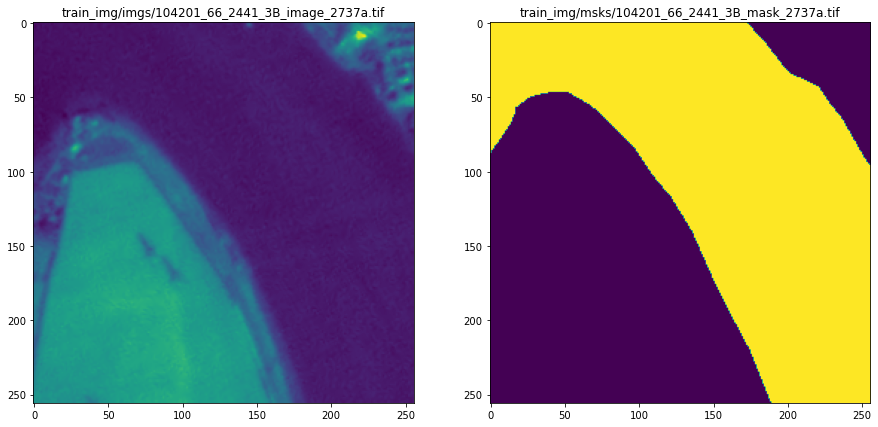

In [13]:
img_idx = 48 # File path List index
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(15, 9))
img0 = tiff.imread(train_imgs[img_idx])
img1 = tiff.imread(train_msk[img_idx])
axs[0].set_title(train_imgs[img_idx])
axs[0].imshow(img0[1,:,:])
axs[1].set_title(train_msk[img_idx])
axs[1].imshow(img1)

In [14]:
img0.shape

(4, 256, 256)

In [15]:
class image_batch(Sequence):
    def __init__(self, image_path_list, mask_path_list, batch_size, image_dims):
        self.image_path_list = image_path_list
        self.mask_path_list = mask_path_list
        self.batch_size = batch_size
        self.image_dims = image_dims 
        
    # Number of batch in the Sequence
    def __len__(self):
        return len(self.image_path_list) // self.batch_size

    # Get sub epochs
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_image_list = self.image_path_list[i : i + self.batch_size]
        batch_mask_list = self.mask_path_list[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.image_dims + (4,), dtype="float32")
        for j, path in enumerate(batch_image_list):
            # img = load_img(path, target_size=self.image_dims)
            img = tiff.imread(path)
            x[j] = np.transpose(img, (1,2,0))

        y = np.zeros((self.batch_size,) + self.image_dims + (1,), dtype="uint8")
        for j, path in enumerate(batch_mask_list):
            # img = load_img(path, target_size=self.image_dims, color_mode="grayscale")
            img = tiff.imread(path)
            y[j] = np.expand_dims(img, 2)
        return x, y

## Build and compile a Deep CNN model based on Unet (Encoder and Decoder) architecture

In [16]:
def segment_model(image_dims, classes):
    input_images = keras.layers.Input(shape=image_dims + (4,))

   # Downsampling block (Encoder layers)
    conv = keras.layers.Conv2D(32, 3, strides=2, padding="same")(input_images)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.Activation("relu")(conv)

    activation_block = conv

    for filters in [64, 128, 256]: #Filters 3 feature depths  
        conv = keras.layers.Activation("relu")(conv)
        conv = keras.layers.SeparableConv2D(filters, 3, padding="same")(conv)
        conv = keras.layers.BatchNormalization()(conv)
        
        conv = keras.layers.Activation("relu")(conv)
        conv = keras.layers.SeparableConv2D(filters, 3, padding="same")(conv)
        conv = keras.layers.BatchNormalization()(conv)
        conv = keras.layers.MaxPooling2D(3, strides=2, padding="same")(conv)

        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(activation_block) # Project residual
        conv = keras.layers.add([conv, residual])  
        activation_block = conv  

    # Upsampling inputs (Decoder layers)

    for filters in [256,128, 64, 32]: # Filters 4 feature depths  
        conv = keras.layers.Activation("relu")(conv)
        conv = keras.layers.Conv2DTranspose(filters, 3, padding="same")(conv)
        conv = keras.layers.BatchNormalization()(conv)

        conv = keras.layers.Activation("relu")(conv)
        conv = keras.layers.Conv2DTranspose(filters, 3, padding="same")(conv)
        conv = keras.layers.BatchNormalization()(conv)

        conv = keras.layers.UpSampling2D(2)(conv)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(activation_block)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        conv = keras.layers.add([conv, residual])  # Add back residual
        activation_block = conv  # Set aside next residual

    # Pixel classification layer
    outputs = keras.layers.Conv2D(classes, 3, activation="softmax", padding="same", name="water_seg_net")(conv)

    # Define and compile the model
#     model = keras.Model(input_images, outputs)
    # loss=tf.keras.losses.BinaryCrossentropy()
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model = keras.Model(inputs=[input_images], outputs=[outputs])
    model.compile(optimizer='rmsprop', loss="sparse_categorical_crossentropy")
    return model
# seg_model = segment_model(image_dims=(256,256), classes=2)
# # seg_model.summary()

In [17]:
image_dims = (256,256)
batch_size = 5
epochs = 20

# Instantiate batch sequence training set
train_batch_generator = image_batch(
    image_path_list = train_imgs, 
    mask_path_list = train_msk,
    batch_size = batch_size,
    image_dims = image_dims
)

# Instantiate batch sequence validation set
valid_batch_generator = image_batch(
    image_path_list = valid_imgs, 
    mask_path_list = valid_msk,
    batch_size = batch_size,
    image_dims = image_dims
)

# Saving models parameters
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath='./SegModels/water_unet_1.hdf5', save_best_only=True)
    # keras.callbacks.EarlyStopping(monitor="val_loss", patience = 10, min_delta=0.0003, restore_best_weights=True)
]

# Training the models
water_model = segment_model(image_dims=image_dims, classes=2) # Call the model 
water_model.fit(train_batch_generator, validation_data=valid_batch_generator, epochs=epochs, callbacks=callbacks) # Fit model 

2022-06-21 17:21:51.400258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 17:21:51.405799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 17:21:51.406054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 17:21:51.406850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/20


2022-06-21 17:21:54.900526: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


118/118 [==============================] - 26s 153ms/step - loss: 0.8558 - val_loss: 0.4727
Epoch 2/20
118/118 [==============================] - 17s 146ms/step - loss: 0.4121 - val_loss: 0.5091
Epoch 3/20
118/118 [==============================] - 17s 143ms/step - loss: 0.3384 - val_loss: 0.3373
Epoch 4/20
118/118 [==============================] - 17s 142ms/step - loss: 0.3267 - val_loss: 0.3519
Epoch 5/20
118/118 [==============================] - 17s 143ms/step - loss: 0.2816 - val_loss: 0.2413
Epoch 6/20
118/118 [==============================] - 17s 142ms/step - loss: 0.2812 - val_loss: 0.2635
Epoch 7/20
118/118 [==============================] - 17s 142ms/step - loss: 0.2473 - val_loss: 0.3176
Epoch 8/20
118/118 [==============================] - 17s 142ms/step - loss: 0.2312 - val_loss: 0.2206
Epoch 9/20
118/118 [==============================] - 17s 141ms/step - loss: 0.2202 - val_loss: 0.2320
Epoch 10/20
118/118 [==============================] - 17s 141ms/step - loss: 0.2289

## Predicting image segmentation 
#### Runing multiple predictions on the SAR valadation images 

In [25]:
pred_directory = 'predicted_files1' # Set folder for the prediction
for idx, path in enumerate(valid_imgs):
    name = path.split('/')[-1]
    val_gen2 = image_batch(
    [valid_imgs[idx]], [valid_msk[idx]], batch_size=1, image_dims=(256,256)
    )

    preds = water_model.predict(val_gen2)
    arr = np.argmax(preds[0], axis=-1)
    dir_ = make_dirs(pred_directory)
    tiff.imwrite(f'{dir_}/{name}', arr)  

1/1 [==============================] - 0s 36ms/step


In [27]:
pred_list = glob.glob(pred_directory + '/*tif')

iou_dict = {'Image':[], 'IOU':[]}
for idx in np.arange(len(valid_imgs)):
    pred_file = pred_list[idx]
    name = os.path.basename(pred_file)
    tile = name.split('_')[0]
    num = name.split('_')[-1]
    # print(tile, num)
    mask_file = [p for p in valid_msk if (tile == os.path.basename(p).split('_')[0]) & (num==os.path.basename(p).split('_')[-1])][0]
    # print(name, mask_file)

    pred_seg = tiff.imread(pred_file)
    pred_seg[pred_seg>0]=1
    mask_seg = tiff.imread(mask_file)
    
    iou_met = MeanIoU(num_classes=2)
    _ = iou_met.update_state(mask_seg, pred_seg)
    iou1 = np.round(iou_met.result().numpy(), 2)
    
    
#     iou = get_iouScore(mask_seg, pred_seg)
#     iou2 = get_iouScore2(actual_img, pred_img, num_classes=2)
    iou_dict['Image'].append(pred_file)
    iou_dict['IOU'].append(iou1)
#     print(f'Image:{name}, IOU:{iou.round(2)}, IOUk:{iou1}')
iou_df = pd.DataFrame(iou_dict)
top_5 = iou_df.sort_values(by='IOU', ascending=False).head(20)
top_5

,Image,IOU
10,predicted_files1/112409_54_2413_3B_image_1143.tif,0.98
13,predicted_files1/104226_00_241e_3B_image_3048a...,0.98
9,predicted_files1/112407_24_2413_3B_image_1838a...,0.97
15,predicted_files1/104226_00_241e_3B_image_2430.tif,0.97
4,predicted_files1/104226_00_241e_3B_image_2939.tif,0.97
16,predicted_files1/104226_00_241e_3B_image_2945.tif,0.95
11,predicted_files1/104226_00_241e_3B_image_178.tif,0.94
0,predicted_files1/104201_66_2441_3B_image_2534a...,0.94
5,predicted_files1/112407_24_2413_3B_image_2232.tif,0.93
19,predicted_files1/104226_00_241e_3B_image_2635a...,0.93


In [60]:
check_file(pred_list, valid_msk)

['image:predicted_files21/NS8088_image_49a.png --> mask:validation_imgs/msks/NS8088_mask_49a.png', 'image:predicted_files21/NS8195_image_103.png --> mask:validation_imgs/msks/NS8195_mask_103.png', 'image:predicted_files21/NS7692_image_94.png --> mask:validation_imgs/msks/NS7692_mask_94.png', 'image:predicted_files21/NS8088_image_614a.png --> mask:validation_imgs/msks/NS8088_mask_614a.png', 'image:predicted_files21/NS7790_image_811.png --> mask:validation_imgs/msks/NS7790_mask_811.png'] 



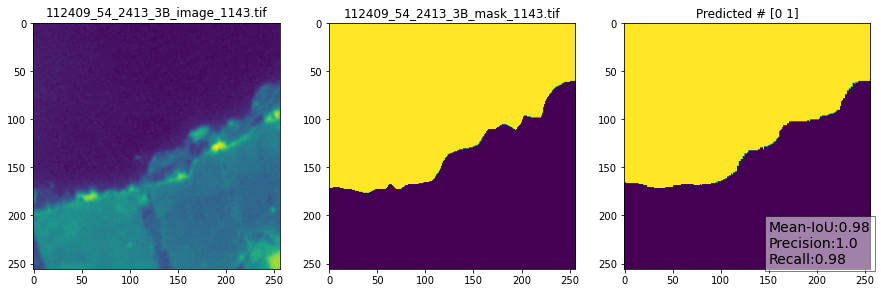

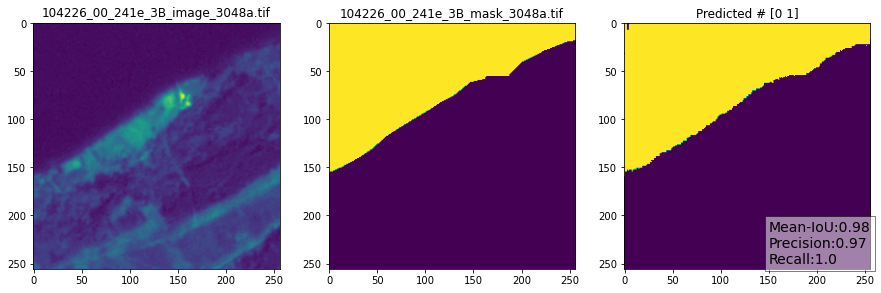

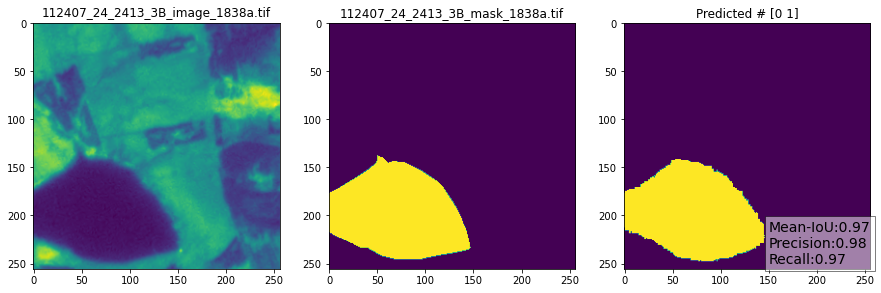

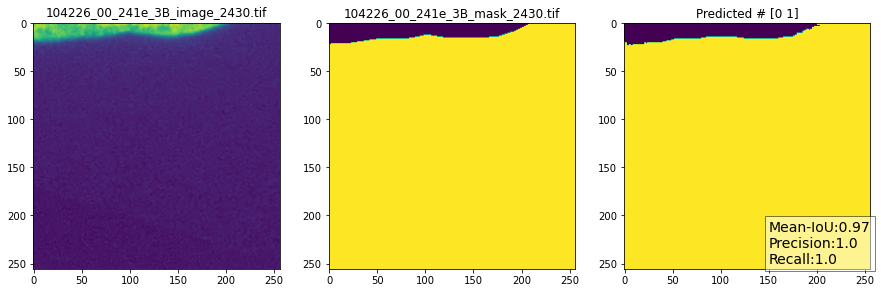

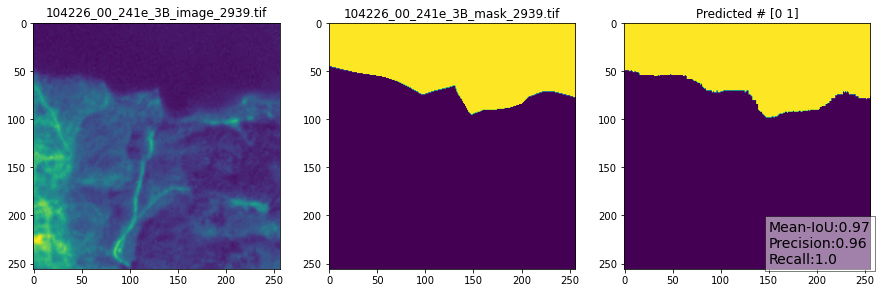

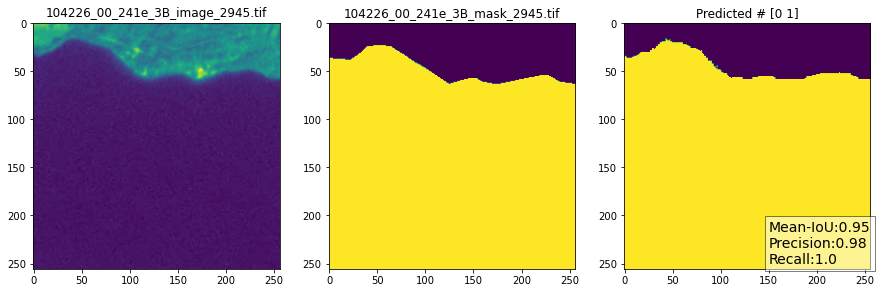

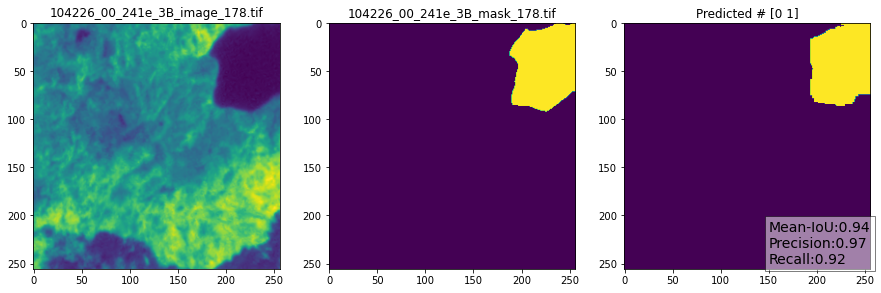

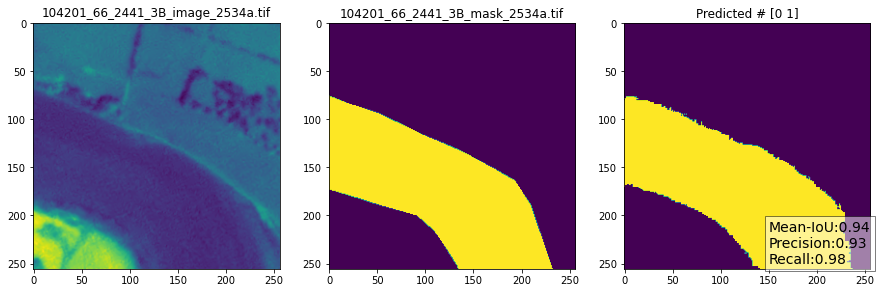

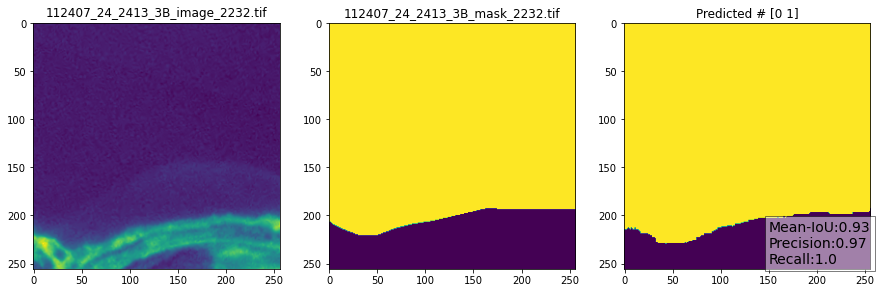

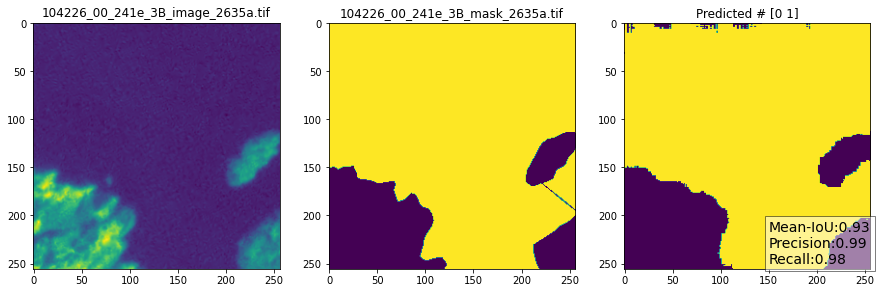

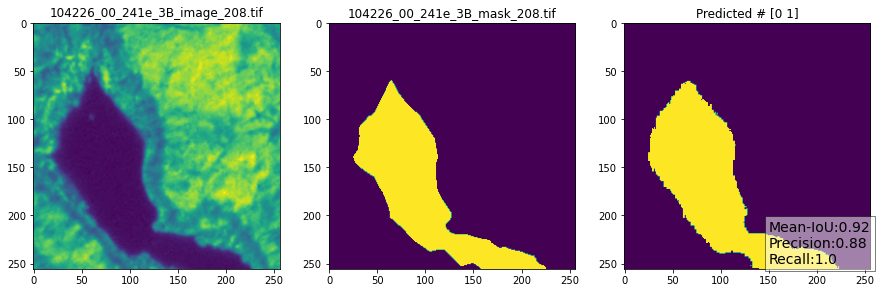

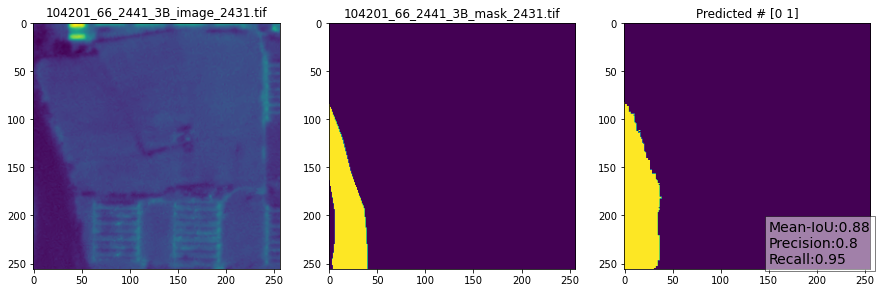

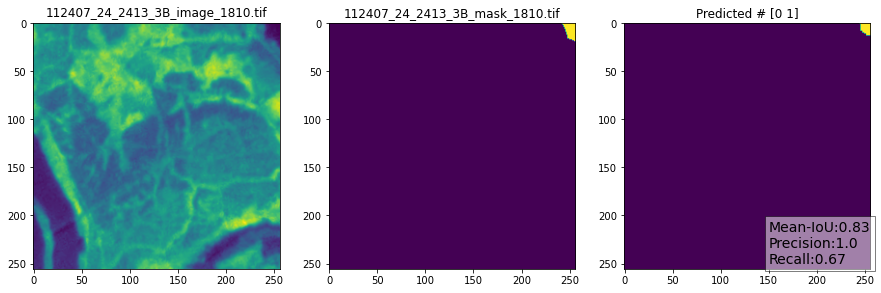

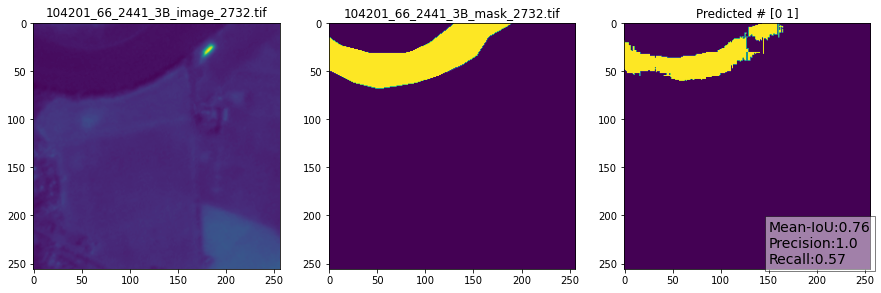

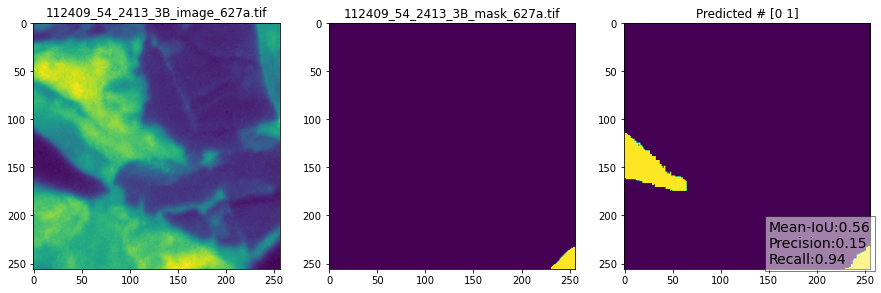

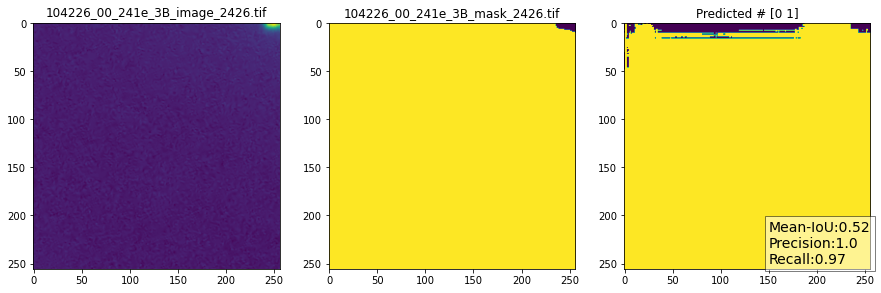

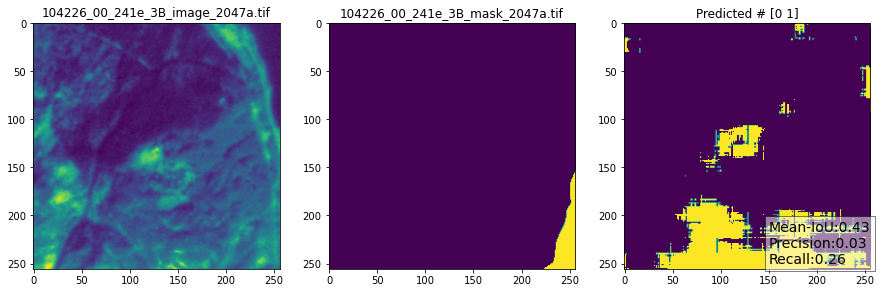

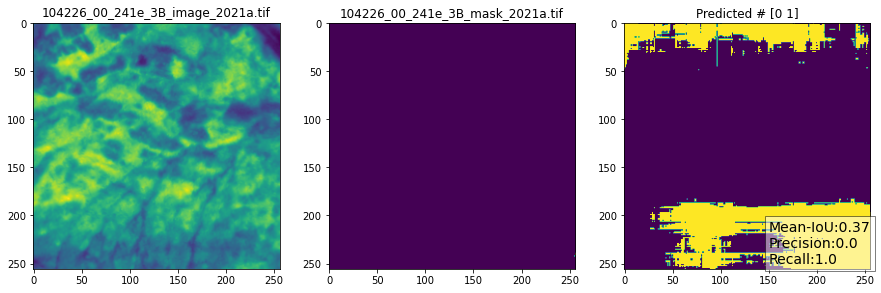

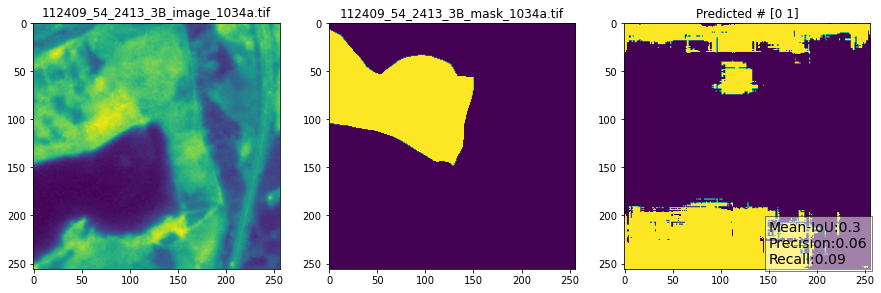

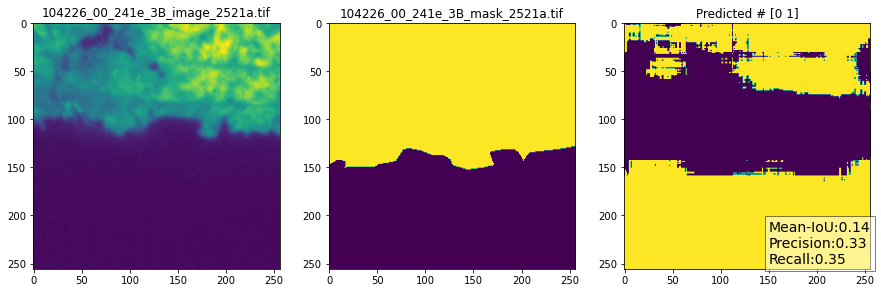

In [40]:


# make a color map of fixed colors
import matplotlib.image as mpimg
cmap = colors.ListedColormap(['blue', 'green'])

for t in top_5.Image.to_list()[:]:
    fn = t.split('/')[-1].split('_')[-1]
    img_file = [m for m in valid_imgs if fn == m.split('/')[-1].split('_')[-1]][0]    
    mask_file = [m for m in valid_msk if fn == m.split('/')[-1].split('_')[-1]][0]
    # pred_file = [m for m in pred_list if t in m][0]
    
    img0 = tiff.imread(img_file)
    img1 = tiff.imread(mask_file)
    img2 = tiff.imread(t)
    img2[img2>0]=1

    rbg_stack = np.dstack(([img0[i,:,:] for i in range(3)]))
    
    eval_mets = get_metrics(img1, img2, num_classes=2)
    iou, pres, rec = eval_mets['Mean-IoU'], eval_mets['Precision'], eval_mets['Recall']
    file = img_file.split('/')[-1]
    mask = mask_file.split('/')[-1]
    fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(15, 9))
    for a, ax in enumerate(axs.reshape(-1)):
        arr = [img0[1,:,:], img1, img2][a]
        cat = [f'{file}',f'{mask}', 'Predicted'][a]
#         file = t.split('.')[1]
        ax.set_title(f'{cat}')
        if cat == 'Predicted':
            ax.set_title(f'{cat} # {np.unique(arr)}' )
            txt = ax.text(x=150, y=250, s=f'Mean-IoU:{np.round(iou, 2)}\nPrecision:{np.round(pres, 2)}\nRecall:{np.round(rec, 2)}', fontsize=14)
            txt.set_bbox(dict(facecolor='white', alpha=0.5))   
        ax.imshow(arr)
# plt.savefig(f'{t}')